# Question 1 Homework 5 ADM

## Prelimiar activities

In [86]:
import os
import pandas as pd
import numpy as np
#import ijson   #uncomment before deliver
import time
from tqdm.notebook import tqdm
import csv
import json
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import heapq
from sortedcontainers import SortedList
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import ast
from collections import defaultdict
import ast
from itertools import combinations
from tabulate import tabulate



In [4]:
os.chdir('/home/laura/Data_Science/ADM/HMW5')
#file_path = 'dblp.v12.json'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

primo metodo per leggere il dataset

In [ ]:
BATCH_SIZE = 10000  # Adjust the batch size as needed
TOTAL_PAPERS = 3000000  # Update with the total number of papers

# Initialize DataFrame columns
columns = ['id', 'num_authors', 'authors', 'n_citation', 'reference_count', 'references']
data_part1 = pd.DataFrame(columns=columns)
data_part2 = pd.DataFrame(columns=columns)

with open(file_path, "rb") as f:
    batch = []

    for i, element in tqdm(enumerate(ijson.items(f, "item")), desc="Processing Papers", unit=" papers", total=TOTAL_PAPERS):
        paper = {}
        paper['id'] = element['id']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            paper['authors'] = [auth for auth in authors]

        n_citation = element.get('n_citation')
        paper['n_citation'] = n_citation if n_citation else 0

        references = element.get('references')
        paper['reference_count'] = len(references) if references else np.nan
        paper['references'] = references if references else np.nan

        batch.append(paper)

        if len(batch) == BATCH_SIZE:
            if i < TOTAL_PAPERS / 2:
                data_part1 = pd.concat([data_part1, pd.DataFrame(batch)], ignore_index=True)
            else:
                data_part2 = pd.concat([data_part2, pd.DataFrame(batch)], ignore_index=True)

            batch = []

    # Add the remaining papers in the last batch
    if i < TOTAL_PAPERS / 2:
        data_part1 = pd.concat([data_part1, pd.DataFrame(batch)], ignore_index=True)
    else:
        data_part2 = pd.concat([data_part2, pd.DataFrame(batch)], ignore_index=True)

# Save the intermediate DataFrames to CSV files
data_part1.to_csv("citations_dataset_part1.csv", index=False)
data_part2.to_csv("citations_dataset_part2.csv", index=False)

In [ ]:
# Load the intermediate datasets
data_part1 = pd.read_csv("citations_dataset_part1.csv")
data_part2 = pd.read_csv("citations_dataset_part2.csv")

# Merge the datasets
final_data = pd.concat([data_part1, data_part2], ignore_index=True)

# Save the final DataFrame to a CSV file
final_data.to_csv("citations_dataset_final.csv", index=False)

secondo metodo per leggere il dataset

In [ ]:
PAPERS = []
BATCH_SIZE = 100000  # Adjust the batch size as needed

with open(file_path, "rb") as f:
    batch = []

    # Wrap the loop with tqdm for a progress bar
    for i, element in tqdm(enumerate(ijson.items(f, "item")), desc="Processing Papers", unit=" papers"):
        paper = {}
        paper['id'] = element['id']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            # joining all authors in a list
            paper['authors'] = [auth for auth in authors]

        n_citation = element.get('n_citation')
        paper['n_citation'] = n_citation if n_citation else 0

        references = element.get('references')
        paper['reference_count'] = len(references) if references else np.nan
        paper['references'] = references if references else np.nan

        batch.append(paper)

        if len(batch) == BATCH_SIZE:
            PAPERS.extend(batch)
            batch = []

    # Add the remaining papers in the last batch
    PAPERS.extend(batch)

da qui in poi codice valido per entrambi i metodi

In [5]:
dataset = pd.read_csv('citations_dataset_final.csv')
dataset

,id,num_authors,authors,n_citation,reference_count,references
0,1091,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",1,2.0,"[2005687710, 2018037215]"
1,1388,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",1,NaN,NaN
2,1674,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",1,15.0,"[1535888970, 1992876689, 1993710814, 203565334..."
3,1688,4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",6,3.0,"[1560724230, 1986968751, 2156909104]"
4,5411,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",0,NaN,NaN
...,...,...,...,...,...,...
4894076,99905544,5.0,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2,8.0,"[1562217771, 1625504505, 2015022770, 210875170..."
4894077,99884553,1.0,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",0,NaN,NaN
4894078,999847014,11.0,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",1,6.0,"[1940933138, 1975620021, 1978183200, 209759592..."
4894079,9990887,2.0,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",0,NaN,NaN


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/HM5/citations_dataset_final.csv')
dataset

In [6]:
column_to_drop_nan_values = 'references'
dataset = dataset.sort_values(by='n_citation', ascending=False)
dataset = dataset.dropna(subset=[column_to_drop_nan_values])
dataset_top_citation = dataset.head(10000)
dataset_top_citation = dataset_top_citation.reset_index(drop=True)
dataset_top_citation

,id,num_authors,authors,n_citation,reference_count,references
0,2151103935,1.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",35541,33.0,"[19720318, 1541642243, 1560959218, 1676552347,..."
1,2911964244,1.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",34741,11.0,"[1507255258, 1580948147, 1605688901, 197584664..."
2,2153635508,2.0,"[{'name': 'Chih-Chung Chang', 'org': 'National...",31047,34.0,"[1510526001, 1543810117, 1556115774, 156879334..."
3,1791587663,1.0,"[{'name': 'Fred D. Davis', 'org': 'Computer an...",25855,22.0,"[157213131, 1520103841, 1778357938, 1972888601..."
4,2119821739,2.0,"[{'name': 'Corinna Cortes', 'org': 'AT&T Bell ...",22276,3.0,"[2087347434, 2154579312, 2168228682]"
...,...,...,...,...,...,...
9995,2124827397,3.0,"[{'name': 'Pawan Goyal', 'org': 'Distributed M...",551,27.0,"[1588883745, 1941732106, 1973544909, 199548424..."
9996,2120894402,4.0,"[{'name': 'Jessica K. Hodgins', 'org': 'Colleg...",551,22.0,"[1798187755, 1967934102, 1987574258, 198770668..."
9997,1982180670,2.0,"[{'name': 'Richard J. Lipton', 'id': 277112432...",551,12.0,"[1530008367, 1980572240, 2026191634, 203462313..."
9998,1559983024,1.0,"[{'name': 'Claudio S. Pinhanez', 'org': 'IBM T...",551,14.0,"[74179108, 137024741, 1987928129, 2007760386, ..."


## Citation graph

In [7]:
dataset_top_citation_citation_graph = dataset_top_citation[['id','references']]
dataset_top_citation_citation_graph

,id,references
0,2151103935,"[19720318, 1541642243, 1560959218, 1676552347,..."
1,2911964244,"[1507255258, 1580948147, 1605688901, 197584664..."
2,2153635508,"[1510526001, 1543810117, 1556115774, 156879334..."
3,1791587663,"[157213131, 1520103841, 1778357938, 1972888601..."
4,2119821739,"[2087347434, 2154579312, 2168228682]"
...,...,...
9995,2124827397,"[1588883745, 1941732106, 1973544909, 199548424..."
9996,2120894402,"[1798187755, 1967934102, 1987574258, 198770668..."
9997,1982180670,"[1530008367, 1980572240, 2026191634, 203462313..."
9998,1559983024,"[74179108, 137024741, 1987928129, 2007760386, ..."


In [8]:
dataset_top_citation_citation_graph['references'] = dataset_top_citation_citation_graph['references'].apply(lambda x: x.replace('[', '').replace(']', '')).copy()
dataset_top_citation_citation_graph['references'] = dataset_top_citation_citation_graph['references'].apply(lambda x: x.split(','))
dataset_top_citation_citation_graph['id'] = dataset_top_citation_citation_graph['id'].astype(str)

/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [9]:
all_ids = dataset_top_citation_citation_graph['id'].tolist()
all_ids = [id_.strip() for id_ in all_ids]
def references_under_id(ids_list):
    return [id_.strip() for id_ in ids_list if id_.strip() in all_ids]
dataset_top_citation_citation_graph['references_under_id'] = dataset_top_citation_citation_graph['references'].apply(references_under_id)
dataset_top_citation_citation_graph = dataset_top_citation_citation_graph.copy()
dataset_top_citation_citation_graph

/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,references,references_under_id
0,2151103935,"[19720318, 1541642243, 1560959218, 16765523...","[1676552347, 1949116567, 2011891945, 202466829..."
1,2911964244,"[1507255258, 1580948147, 1605688901, 197584...","[1605688901, 1975846642, 2112076978, 211324281..."
2,2153635508,"[1510526001, 1543810117, 1556115774, 156879...","[1510526001, 1568793342, 1621799579, 205698353..."
3,1791587663,"[157213131, 1520103841, 1778357938, 1972888...","[1972888601, 1988410705, 2037021532, 209248890..."
4,2119821739,"[2087347434, 2154579312, 2168228682]","[2087347434, 2154579312]"
...,...,...,...
9995,2124827397,"[1588883745, 1941732106, 1973544909, 199548...","[2073440460, 2098289156, 2098375698, 209944078..."
9996,2120894402,"[1798187755, 1967934102, 1987574258, 198770...","[2117085697, 2127197749, 2150312211, 2293545866]"
9997,1982180670,"[1530008367, 1980572240, 2026191634, 203462...",[]
9998,1559983024,"[74179108, 137024741, 1987928129, 200776038...","[2140235142, 2149891956, 2158683916, 2237155658]"


In [10]:
G = nx.DiGraph()
G.add_nodes_from(dataset_top_citation_citation_graph['id'])
for _, row in dataset_top_citation_citation_graph.iterrows():
    source_node = row['id']
    target_node = row['references_under_id']
    G.add_edges_from([(source_node, target_node) for target_node in target_node])

In [11]:
graph_data = nx.node_link_data(G)


In [ ]:
graph_data = nx.node_link_data(G)

# Store as json file for the Command Line purpose
with open('/content/drive/MyDrive/HM5/grafo1.json', 'w') as json_file:
    json.dump(graph_data, json_file)

In [12]:
with open('/content/drive/MyDrive/HM5/grafo1.json', 'r') as json_file:
    loaded_graph_data = json.load(json_file)

# Loading the graph to be used
loaded_G = nx.node_link_graph(loaded_graph_data)

# Verify that two graphs have same attributes
print("Original graph:", G.number_of_edges())
print("Loaded graph:", loaded_G.number_of_edges())

Original graph: 55150
Loaded graph: 55150


In [12]:
loaded_G = nx.node_link_graph(graph_data)

# Verify that two graphs have same attributes
print("Original graph:", G.number_of_edges())
print("Loaded graph:", loaded_G.number_of_edges())

Original graph: 55150
Loaded graph: 55150


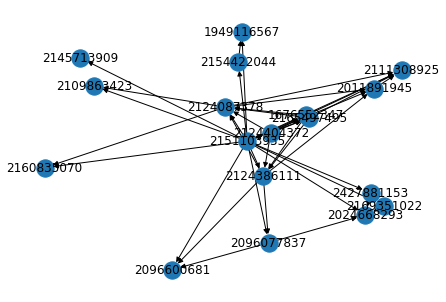

In [14]:
first_node_to_show = dataset_top_citation_citation_graph.iloc[0]
source_node = first_node_to_show['id']
target_node = first_node_to_show['references_under_id']
subgraph_nodes = [source_node] + target_node
subgraph = G.subgraph(subgraph_nodes)
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, arrowsize=10)
plt.show()

## Collaboration graph

In [15]:
dataset_top_citation_collaboration_graph = dataset_top_citation[['authors']]
dataset_top_citation_collaboration_graph

,authors
0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc..."
1,"[{'name': 'Leo Breiman', 'org': 'Statistics De..."
2,"[{'name': 'Chih-Chung Chang', 'org': 'National..."
3,"[{'name': 'Fred D. Davis', 'org': 'Computer an..."
4,"[{'name': 'Corinna Cortes', 'org': 'AT&T Bell ..."
...,...
9995,"[{'name': 'Pawan Goyal', 'org': 'Distributed M..."
9996,"[{'name': 'Jessica K. Hodgins', 'org': 'Colleg..."
9997,"[{'name': 'Richard J. Lipton', 'id': 277112432..."
9998,"[{'name': 'Claudio S. Pinhanez', 'org': 'IBM T..."


In [16]:
dataset_top_citation_collaboration_graph['authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace('[', '').replace(']', '')).copy()
dataset_top_citation_collaboration_graph['authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace('{', '').replace('}', '')).copy()
dataset_top_citation_collaboration_graph['authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace(':', '')).copy()
dataset_top_citation_collaboration_graph['authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace('David', '')).copy()
dataset_top_citation_collaboration_graph['authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.split(','))
dataset_top_citation_collaboration_graph['authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda authors: list(filter(lambda author: 'id' in author, authors)))
dataset_top_citation_collaboration_graph

/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,authors
0,[ 'id' 2104328312]
1,[ 'id' 2569376642]
2,"[ 'id' 2895256545, 'id' 2168176072]"
3,[ 'id' 2427477170]
4,"[ 'id' 2134830209, 'id' 2022407533]"
...,...
9995,"[ 'id' 2152918269, 'id' 2020627909, 'id' 266..."
9996,"[ 'id' 601642093, 'id' 1980379243, 'id' 2030..."
9997,"[ 'id' 2771124329, 'id' 350567680]"
9998,[ 'id' 320969846]


In [17]:
def clean_strings_authors(lst):
    cleaned_list = []
    for x in lst:
        ids_authors_only = ''.join(char for char in x if char.isdigit())
        if ids_authors_only:
            cleaned_list.append(int(ids_authors_only))
    return cleaned_list

dataset_top_citation_collaboration_graph['authors'] = dataset_top_citation_collaboration_graph['authors'].apply(clean_strings_authors)
dataset_top_citation_collaboration_graph

/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,authors
0,[2104328312]
1,[2569376642]
2,"[2895256545, 2168176072]"
3,[2427477170]
4,"[2134830209, 2022407533]"
...,...
9995,"[2152918269, 2020627909, 2662983009]"
9996,"[601642093, 1980379243, 2030310643, 2104748382]"
9997,"[2771124329, 350567680]"
9998,[320969846]


In [18]:
G_collaboration = nx.Graph()

for _, row in dataset_top_citation_collaboration_graph.iterrows():
    author_list = row['authors']
    for collaboration in itertools.combinations(author_list, 2):
        if G_collaboration.has_edge(*collaboration):
            G_collaboration[collaboration[0]][collaboration[1]]['weight'] += 1
        else:
            G_collaboration.add_edge(*collaboration, weight=1)

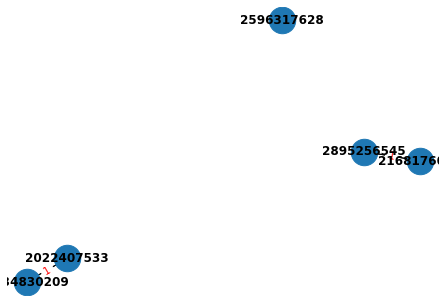

In [19]:
nodes_to_show = list(G_collaboration.nodes())[:5]
subgraph_collaboration = G_collaboration.subgraph(nodes_to_show)
pos = nx.spring_layout(subgraph_collaboration)
nx.draw(subgraph_collaboration, pos, with_labels=True, font_weight='bold', node_size=700)
edge_weights = {(i, j): subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()}
nx.draw_networkx_edges(subgraph_collaboration, pos, width=[subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()])
nx.draw_networkx_edge_labels(subgraph_collaboration, pos, edge_labels=edge_weights, font_color='red')

import matplotlib.pyplot as plt
plt.show()

# **[Q2] Controlling system**

The objective is to establish a control system where the user will be presented with a menu containing various functionalities. The user should have the ability to choose from five different functionalities, which will be implemented in the upcoming two sections. This system is designed to enable users to query and access functionalities of interest

# suggestion: remove and make alltogether backend and frontend as I already "did" some frontend application (and remove 2.1 backend implemented text cell: ONLY TITLE)

## **2.1 Backend implementation**

 In this section we implement the different functionalities as classes and we can find the implementation in the corrispondent python files

### **Functionality 1 - Graph's features**

This function should examine a graph and report on some of its features.
In particular we're interested in the: **The number of the nodes**, **number of edges**, **density**, **degree distribution**, **average degree**, **graph hubs** and finally a boolean values if the graph is **dense** or sparse.

The particolar threshold of density we consider `0.6` as moltiplicative factor as, typically, NOT dense graph has really lower number of edges r.t.w. the maximum number of edges. We also like this assessment as we consider it logical

we can address the functionalities rispectilvly calling the following methods      
> nnodes

> nedges

> density

> degreedistr

> averagedegree

> hubs

> isdense


In [21]:
from feature1 import GetFeature1
g = GetFeature1(G, 'fake')

In [22]:
# As asked only 10000 nodes were selected among all nodes
g.nnodes

10000

In [23]:
# Calculating the number of edges
g.nedges

55150

In [24]:
#density of the graph
round(g.density,5)

0.00055

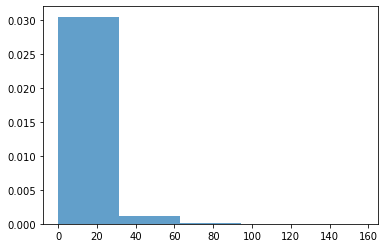

In [25]:
# We have a very raugh representation of the degree distribution
# We find the number of nodes on the x label and the density on the y "axis"
g.degreedistr

Recalling that  a hub in graph theory refers to a node with a high degree, connected to a large number of other nodes in the network. They are often identified based on their high degree centrality, which quantifies the number of connections a node has.

Some nodes from the list of hubs are printed.

In [26]:
# We select some random nodes which are hubs
g.hubs[450:455] # are 456 in total

['2128749719', '1772076007', '2167050549', '2141167937', '2108767394']

In [27]:
g.isdense

False

We found the density through networkx, but levaraging the followinf formula for the density of a graph G with $n$ nodes and $m$:

$$D=\dfrac{2m}{n⋅(n−1)}$$

For our graph with 10.000 nodes and 55.140 edges we have:

$$D=\dfrac{2\cdot55.140}{10.000⋅(10.000−1)}\approx 0.0011$$​

whose density is really far off for any reasonable threshold that a graph is dense

In [33]:
g.hubs

['2151103935',
 '2911964244',
 '2153635508',
 '1791587663',
 '2119821739',
 '2145023731',
 '2161969291',
 '1880262756',
 '1686810756',
 '1522301498',
 '2133665775',
 '2121863487',
 '2163605009',
 '2132984323',
 '2064675550',
 '2296616510',
 '2169528473',
 '2194775991',
 '2100379340',
 '2104095591',
 '2173213060',
 '2159080219',
 '2139212933',
 '2912934387',
 '2164598857',
 '2141885858',
 '2166559705',
 '2137401668',
 '2148606196',
 '2066636486',
 '1996360405',
 '2107080958',
 '2149706766',
 '2618530766',
 '2137983211',
 '2049981393',
 '1988790447',
 '2145096794',
 '2108598243',
 '2106335692',
 '2110425399',
 '2121947440',
 '2152121970',
 '2156186849',
 '1660562555',
 '2598771954',
 '2124386111',
 '2130509920',
 '2949650786',
 '1992419399',
 '2095705004',
 '2071707134',
 '2118428193',
 '2147152072',
 '2121647436',
 '2117539524',
 '2111308925',
 '2163352848',
 '1673310716',
 '2119479037',
 '2099574482',
 '2147880316',
 '2150134853',
 '2118877769',
 '1677409904',
 '2342091124',
 '20971177

### **Functionality 2 - Nodes' contribution**

Using this functionality, we can identify the papers/authors who have significantly contributed to this field of study. In order to achieve a more complete analysis we will examine the graph using various centrality measurements such as **betweeness**, **pageRank**, **closeness**, **centrality**.

We can call it as methods of aour class through the following instructions:
### **nodecentrality**

The betweenness centrality B(x) of a node $x$ is calculated based on the number of shortest paths that pass through $x$, normalized by the total number of shortest paths in the network:

$$B(x)=∑_{s\neq x \neq t}\dfrac{σ_{st}(x)}{σ_{st}}$$

Where:

  $σ_{st}​$ is the total number of shortest paths from node $s$ to node $t$.

  $σ_{st}​(x)$ is the number of those paths that pass through node $x$.


### **pagerank**

Pagerank is a link analysis algorithm used by search engines to assign a numerical weight to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of measuring its relative importance within the set

### **closeness**

The closeness centrality is a measure of a node's centrality within a graph, which gauges how close a node is to all other nodes. For an undirected graph, the closeness centrality (C(v)) of a node v is defined as the reciprocal of the sum of the shortest distances from v to all other nodes in the graph:

$$\displaystyle C(v)=\dfrac{1}{\sum_{u}d(v,u)}$$

Here, $d(v,u)$ represents the shortest distance between nodes v and u. For a directed graph, closeness centrality is generally defined similarly, but considering only reachable or incoming nodes.

### **degreecentrality**
The degree centrality D(x) of a node $x$ is the number of edges incident to that node, normalized by the total number of nodes in the network minus one:

$$D(x)=\dfrac{\text{Number of edges incident to x}}{N-1}​$$

where $N$ is the total number of nodes in the network.

In [78]:
from feature2 import GetFeature2

#### Example 1

In [79]:
h = GetFeature2(subgraph, '2151103935', 'citation subgraph')
h.closeness

0.0

In [80]:
round(h.pagerank,5)

0.03139

In [46]:
h.nodecentrality

0.0

In [47]:
h.degreecentrality

1.0

#### Example 2

In [81]:
h1 = GetFeature2(subgraph, '1676552347', 'citation subgraph')
round(h1.closeness,5)


0.11765

In [77]:
round(h1.pagerank,5)

0.03997

In [80]:
round(h1.nodecentrality,5)

0.00123

In [82]:
round(h1.degreecentrality,5)

0.35294

In [82]:
table = [ ['Concerned Node', '2151103935', '1676552347' ], ['Closeness Centrality',h.closeness, round(h1.closeness,5)],\
        ['pagerank', round(h.pagerank,5) ,round(h1.pagerank,5)],["degree centrality", round(h.degreecentrality,5), round(h1.degreecentrality,5)], 
        ["Node centrality", round(h.nodecentrality,5), round(h1.nodecentrality,5)]]


In [90]:
print(tabulate(table,numalign="right"))

--------------------  ----------  -----------
Concerned Node        2.1511e+09  1.67655e+09
Closeness Centrality           0      0.11765
pagerank                 0.03139      0.03997
degree centrality              1      0.35294
Node centrality                0      0.00123
--------------------  ----------  -----------


### **Functionality 3 - Shortest ordered walk**

In this functionality we're asked to find the shortest orderd walks. We have in input: the graph data, a sequence of authors_a and initial and a final node and a number N. As output we want  to get from author a_1 to author a_n and the papers you need to cross to realize this walk.

It returns a message when the graph is not fully connected neither exists a shortest path between two specified nodes.

We decided to return the shortest path also when a list is not given.

In the specific case of the **Collaboration graph**, as it is not so dense, we decide non to use this parameter for the sake of visualization as it would be of no interest.

**N is a parameter to filter the first authors with respect to the number of papers they have written**. Furthermore the choice of weights in the collaboration graphs was free and we decided to pick the number of collaborations.

So choose the top N authors we decide to extract the exact number of papers from the real dataset and not approximated from the graph. Indeed summing the outgoing edges would at least exclude two hihgly probably cases:

1. articles publishes solitarly
2. the case in which an article was written by 3 hands there would be 2 connections but the article would still be one


We therefore extract the top authors in the followings cell of code


In [91]:
dataset_top_citation

,id,num_authors,authors,n_citation,reference_count,references
0,2151103935,1.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",35541,33.0,"[19720318, 1541642243, 1560959218, 1676552347,..."
1,2911964244,1.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",34741,11.0,"[1507255258, 1580948147, 1605688901, 197584664..."
2,2153635508,2.0,"[{'name': 'Chih-Chung Chang', 'org': 'National...",31047,34.0,"[1510526001, 1543810117, 1556115774, 156879334..."
3,1791587663,1.0,"[{'name': 'Fred D. Davis', 'org': 'Computer an...",25855,22.0,"[157213131, 1520103841, 1778357938, 1972888601..."
4,2119821739,2.0,"[{'name': 'Corinna Cortes', 'org': 'AT&T Bell ...",22276,3.0,"[2087347434, 2154579312, 2168228682]"
...,...,...,...,...,...,...
9995,2124827397,3.0,"[{'name': 'Pawan Goyal', 'org': 'Distributed M...",551,27.0,"[1588883745, 1941732106, 1973544909, 199548424..."
9996,2120894402,4.0,"[{'name': 'Jessica K. Hodgins', 'org': 'Colleg...",551,22.0,"[1798187755, 1967934102, 1987574258, 198770668..."
9997,1982180670,2.0,"[{'name': 'Richard J. Lipton', 'id': 277112432...",551,12.0,"[1530008367, 1980572240, 2026191634, 203462313..."
9998,1559983024,1.0,"[{'name': 'Claudio S. Pinhanez', 'org': 'IBM T...",551,14.0,"[74179108, 137024741, 1987928129, 2007760386, ..."


#### find the authors with the higher number of articles published

In [92]:
# We consider the original dataset to have the orginal number of total papers published
top_authors= dataset[['id','authors']]
top_authors

,id,authors
2937610,2151103935,"[{'name': 'David G. Lowe', 'org': 'Computer Sc..."
4088311,2911964244,"[{'name': 'Leo Breiman', 'org': 'Statistics De..."
2691785,2153635508,"[{'name': 'Chih-Chung Chang', 'org': 'National..."
688041,1791587663,"[{'name': 'Fred D. Davis', 'org': 'Computer an..."
2313078,2119821739,"[{'name': 'Corinna Cortes', 'org': 'AT&T Bell ..."
...,...,...
1443467,2032881500,"[{'name': 'Tong Zhu', 'org': 'Dept. of Comput...."
1443452,2032879541,"[{'name': 'John Ayoade', 'org': 'American Univ..."
1443458,2032880699,"[{'name': 'Adrian Rusu', 'org': 'Dept. of Comp..."
1443466,2032881482,"[{'name': 'Óscar J. Rubio', 'org': 'Aragon In..."


In [93]:
# We see how our data is structured and how authors-ids are stored
top_authors['authors'][0]

"[{'name': 'Makoto Satoh', 'org': 'Shinshu University', 'id': 2312688602}, {'name': 'Ryo Muramatsu', 'org': 'Shinshu University', 'id': 2482909946}, {'name': 'Mizue Kayama', 'org': 'Shinshu University', 'id': 2128134587}, {'name': 'Kazunori Itoh', 'org': 'Shinshu University', 'id': 2101782692}, {'name': 'Masami Hashimoto', 'org': 'Shinshu University', 'id': 2114054191}, {'name': 'Makoto Otani', 'org': 'Shinshu University', 'id': 1989208940}, {'name': 'Michio Shimizu', 'org': 'Nagano Prefectural College', 'id': 2134989941}, {'name': 'Masahiko Sugimoto', 'org': 'Takushoku University, Hokkaido Junior College', 'id': 2307479915}]"

In [94]:
# We construct our counter as a dictionary
authors_publishedict = defaultdict(int)

for idx, row in top_authors.iterrows():
    authors = row['authors']

    # Iterate over author dictionaries in the 'authors' columns list
    for auth_dict in ast.literal_eval(authors):
        author_id = auth_dict.get('id')

        # Count the occurrences of each author_id in authors_publishedict
        authors_publishedict[author_id] += 1



In [95]:
# Add  a new column to the dataset so we can filter about top-N authors
authors_publisheddf= pd.DataFrame(list(authors_publishedict.items()), columns=['id', 'PublicationCount'])

In [96]:
path_csv = '/content/authors_publisheddf.csv'
authors_publisheddf.to_csv(path_csv, index=False)

In [96]:
new_df = authors_publisheddf.sort_values(by='PublicationCount', ascending=False)
new_df

,id,PublicationCount
4650,1976698169,1290
13109,703410400,1153
1919,2125104194,1135
5920,2029230138,1084
10259,688402840,1061
...,...,...
1667906,2529296952,1
1667905,2168883319,1
1667904,2974858411,1
1667901,2438493545,1


#### To implement the thirs feature we need some more function which, for readibility, we stored in a python file. We check all details there: you will find

> **extract (graph, N)**: the function that filters for the top N authors

> **dijkstra (graph, start, stop)** : a function which finds the shortest path for a weighted graph between the first and the end node

> **connectauthor (graph, start, end, list)**: a function that returns the shortest connected graph which considers visiting all the node in the list in that order.

In [102]:
# Importing our function
import feature3file as f3

FileNotFoundError: [Errno 2] No such file or directory: '/media/alberto/STORE N GO/cartellaprovvisorio/authors_publisheddf.csv'

In [115]:
# An example
f3.connectauthor(G_collaboration, 2104401652, 2027658599, 150, [2007415138] )

[2104401652,
 351197510,
 2435751034,
 2128170596,
 1978529654,
 1973035492,
 2159063947,
 2007415138,
 2027658599]

How is the subgraph? Is it enough dense to get some reasonable path? We visualize it leveraging some previous code

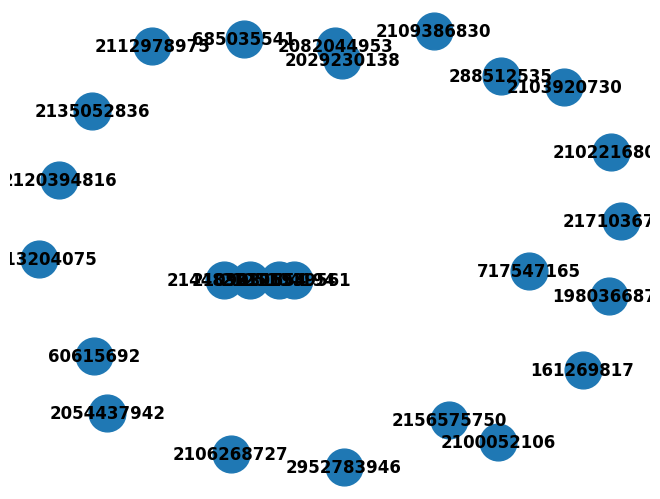

In [108]:
# Selecting a subgraph with the top 120 authors
subres =f3.extract(G_collaboration, 120)

#See code in exercise1
nodes_to_show_sub = list(subres.nodes())[:25]
subgraph_collaboration = subres.subgraph(nodes_to_show_sub)
pos = nx.spring_layout(subgraph_collaboration)
nx.draw(subgraph_collaboration, pos, with_labels=True, font_weight='bold', node_size=700)
edge_weights = {(i, j): subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()}
nx.draw_networkx_edges(subgraph_collaboration, pos, width=[subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()])
nx.draw_networkx_edge_labels(subgraph_collaboration, pos, edge_labels=edge_weights, font_color='red')

plt.show()

In [130]:
subres.number_of_nodes()

82

In [131]:
subres.number_of_edges()

10

In [129]:
# Filtered by top N author
f3.connectauthor(subres, 2029230138, 2082044953, 150)

[2029230138, 2082044953]

#### As subgraph had only few edges (only 10!) we decide to plot with some different strategy w.r.t the one asked. We will proceed anagously for the fourth feature.

**Functionality 4 - Disconnecting Graphs**

The functionality is designed to calculate the minimum number of edges (taking into account their weights) required to disconnect the original graph into two disconnected subgraphs, denoted as G_a and G_b.

---

**In the code we left some commented code to get the total weight of the minum mincut but by definition getting a minim number of edges is just a number and does not depend on the weights.**


Indeed if we have two possibility of having the same number of edges with different combination of edges such to have different cost we will still get the same number of minimum number of edges.

---



#### Karger a randdomized algorithm

Yes, the **Karger**'s algorithm is a randomized algorithm, which means that its result can vary across different executions of the same input. Randomization is introduced in the choice of edges to contract during the graph contraction process. This randomness is used to achieve a higher probability of contracting edges that lead to the correct solution.

Karger's algorithm works through a series of random contractions of graph edges until only two nodes remain, representing the remaining connected components. The randomness in the algorithm increases the probability of obtaining an approximate solution, but not necessarily the optimal one, in reasonable time.

In summary, randomization in Karger's algorithm is used as a strategy to more effectively explore the solution space and obtain approximate results in reasonable times.

In [100]:
import feature4 as f4


**AS IT IS A PROBABILISTIC ALGORITHIM WE THEN PERFORM THE OPERATION 10 TIMES BY DEFAULT AND TAKE THE NUMBER OF EDGES THAT MINIMIZES THE TOTAL COST**

Moreover we implement the functionality such that it returns not only the minimum numbers of the edges but all the path as couples of edges as it is the correct format if we want to remove it from the original graph and return also the weight of the nodes excluded edges so to consider the fact the graph is weighted.


---

**This would already be a reasonable solution** that considers the weights: if we define a distance function that equals one if two nodes are different and zero if we consider the same node; we can then consider a rule that takes into account positive distance with weights.

As the request has several possible interpretretations and **as it is a probabilistic algorithm, it might be useful to repeat the experiment several times and see the solution with the minimum weight**.

#### this is the road we will follow




#### To implement the thirs feature we need some more function which, for readibility, we stored in a python file. We check all details there: you will find

> **find_components_dfs (graph)**: the function that finds all connected components in a graph

> **contract_edge (graph, node1, node2)** : a function which returns the new graph whith the contracted nodes and edges adjusted appropriatly

> **custom_karger (graph, start, end, list)**: a function that returns the shortest minicut choosing randomly the edges to select

> **considerweight(graph, start, end, it=10)**: Iterates to get the minicut $it$
times

> **weigthedmincut(list of the resulst)**: select the result with the minimum weight minicut

We list which nodes will be removed

In [111]:
f4.custom_karger(G_collaboration, 2104401652, 2027658599)

RuntimeError: dictionary changed size during iteration

In [26]:
#We find the minimum number of edges through calculating the length
minremove= len(f4.custom_karger(G_collaboration, 2104401652, 2027658599))
minremove

12

In [84]:
import feature4 as f4

In [81]:
f4.custom_karger(subgraph, 2145713909, 2151103935)

[(2145713909, 2151103935)]

### **Functionality 5 - Extracting Communities**

In [39]:
from feature5 import functionality5

In [35]:
G1 =loaded_G 

In [65]:
G_undirected = G1.to_undirected()
# Calculate the degree centrality for each node and select the top N nodes
degree_centrality = nx.degree_centrality(G_undirected)
top_N_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:50]
random.seed(1234)
paper1, paper2 = random.sample(top_N_nodes, 2)

In [66]:
print(f'paper1: {paper1} and paper2: {paper2}')

paper1: 2154422044 and paper2: 2066636486


In [67]:
min_edge_removed, communities, same_community = functionality5(G1, N=50, paper1='2154422044', paper2='2066636486')
print(min_edge_removed, communities, same_community)

0 [['2147800946', '2163922914', '2165949425', '2131846894', '2108598243', '1988790447', '2066636486', '2161969291', '1880262756', '2151103935', '2154422044', '2102605133', '1971784203', '2150341604', '2076063813', '1686810756', '2064675550', '1986931325', '2296616510', '2618530766', '1995903777', '2912934387', '2119821739', '2117539524', '2163605009', '2031489346', '2072128103', '2164598857', '2168356304', '2162915993', '2124386111', '2147152072', '2121947440', '2104095591', '2153635508', '2132984323'], ['2141885858', '2096525273'], ['1660562555'], ['1791587663', '2100408980', '1987198869'], ['2132932625', '2157457404', '2148251644'], ['1996360405', '2156186849'], ['2159080219', '47957325'], ['2130509920']] 0


In [72]:
num_communities = len(communities)
num_communities

8

As we can see we have a list with all the comunities, 8 in this example.
We also can see that in this example the two nodes are in the same community

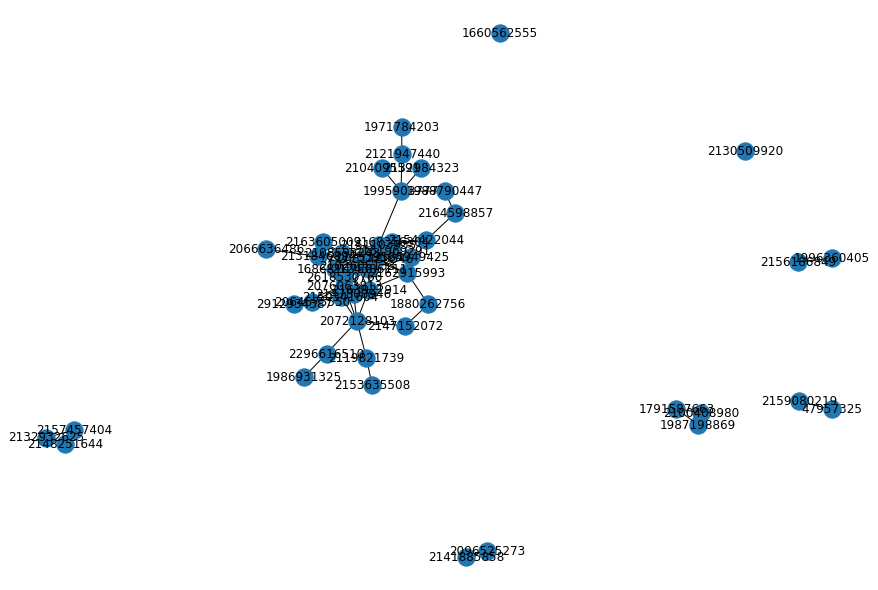

In [73]:
plt.figure(figsize=(12, 8))
G_N = G_undirected.subgraph(top_N_nodes)
nx.draw(G_N, with_labels = True)


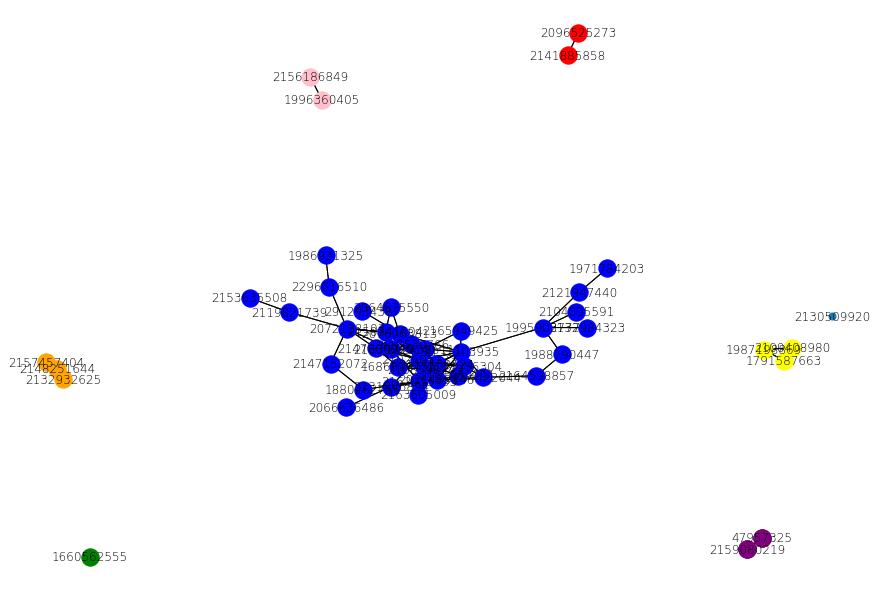

In [76]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_N)
nx.draw(G_N, pos, edge_color='k',  with_labels=True,
     font_weight='light', node_size= 50, width= 1, arrowsize=10)
nx.draw_networkx_edges(G_N, pos, edge_color='black')


#For each community list, draw the nodes, giving it a specific color.
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[0], node_color='b')
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[1], node_color='r')
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[2], node_color='g')
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[3], node_color='yellow')
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[4], node_color='orange')
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[5], node_color='pink')
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[6], node_color='black')
nx.draw_networkx_nodes(G_N, pos, nodelist=communities[6], node_color='purple')

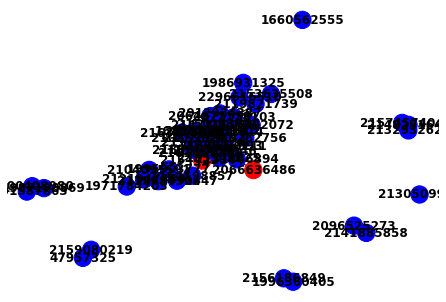

In [75]:
papers_nodes = [paper1, paper2]

# Create a list of colors for each node
node_colors = ['red' if node in papers_nodes else 'blue' for node in G_N.nodes]

# Draw the graph with specified node colors
nx.draw(G_N, with_labels=True, node_color=node_colors, font_weight='bold')

# Show the plot
plt.show()

The two nodes in red represent the papers, that in this case are in the same community

# Command Line